# **Trabalho Prático: Classificação (Fase 3)**

**Alunos:**  
Isabelle Fernandes de Oliveira   
Arthur Gontijo Queiroz da Silveira

## 1. Recapitulação:
Na Fase 2, foram desenvolvidos diversos modelos de classificação com o objetivo de prever o tipo de treino ideal para cada cliente, utilizando características biológicas e comportamentais, como nível de experiência, ingestão de água, frequência semanal de treino e duração das sessões.

Embora alguns resultados iniciais tenham sido promissores, um aspecto importante que não foi avaliado pelo LLM foi a viabilidade dos dados para a tarefa de classificação, tema que será abordado na próxima seção. Além disso, a escolha dos hiperparâmetros dos modelos foi realizada de forma arbitrária, sem justificativas ou otimizações, o que será corrigido nesta etapa utilizando GridSearch para aprimorar a seleção de parâmetros.

## 2. Viabilidade do Problema:

Durante a Fase 2, identificamos dois indícios importantes que sugerem que modelos de classificação podem não ser a abordagem mais adequada para essa tarefa:

- A acurácia obtida pelos modelos foi muito baixa, inclusive inferior à de um classificador aleatório, indicando dificuldade em distinguir as classes com base nos dados disponíveis.

- Análises exploratórias, incluindo visualizações gráficas das distribuições das variáveis numéricas e categóricas em relação ao tipo de treino, mostraram pouca separabilidade entre as classes. Essa baixa distinção sugere que as características disponíveis não apresentam variações relevantes que permitam discriminar de forma eficaz os diferentes tipos de treino.

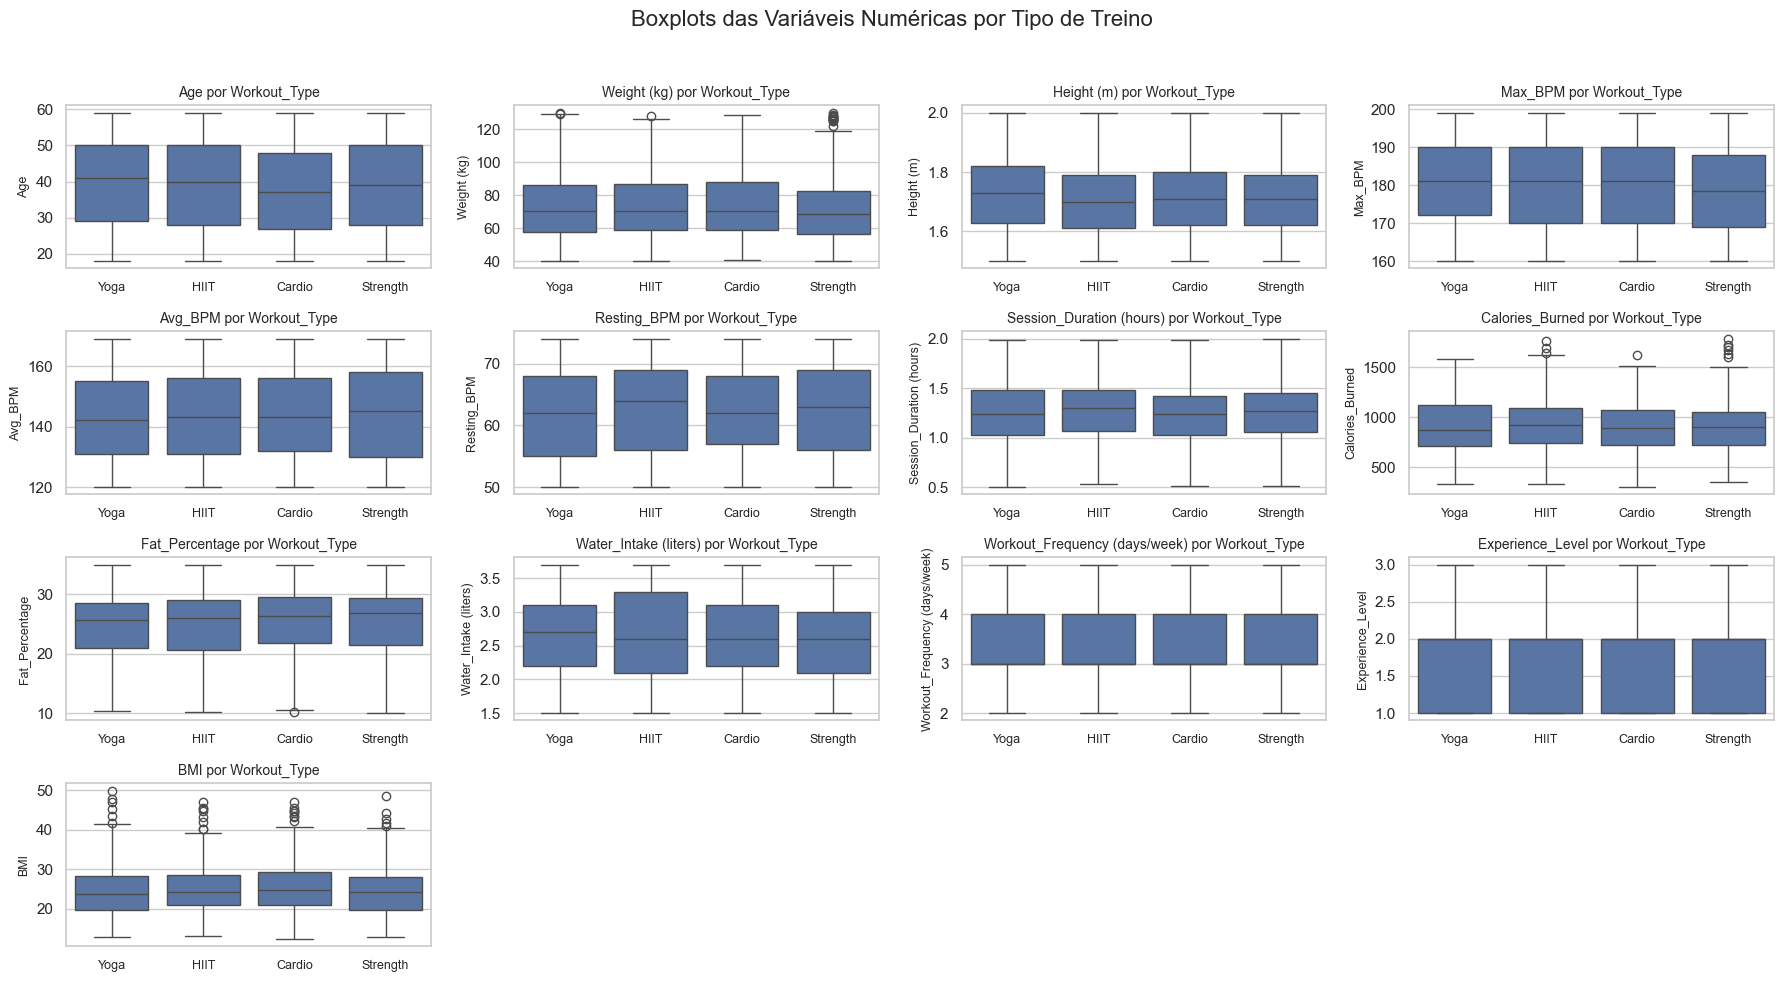

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("gym_members_exercise_tracking.csv", sep=",")

numeric_cols = df.select_dtypes(include='number').columns
num_cols = len(numeric_cols)

sns.set_theme(style="whitegrid")
n_rows = 4
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))

axes = axes.flatten()
target = 'Workout_Type'

for i, col in enumerate(numeric_cols):
        
    sns.boxplot(data=df, x=target, y=col, ax=axes[i])
    
    axes[i].set_title(f'{col} por {target}', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col, fontsize=9)
    axes[i].tick_params(axis='x', labelsize=9)

# Remove os plots que nao foram usados
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Boxplots das Variáveis Numéricas por Tipo de Treino', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

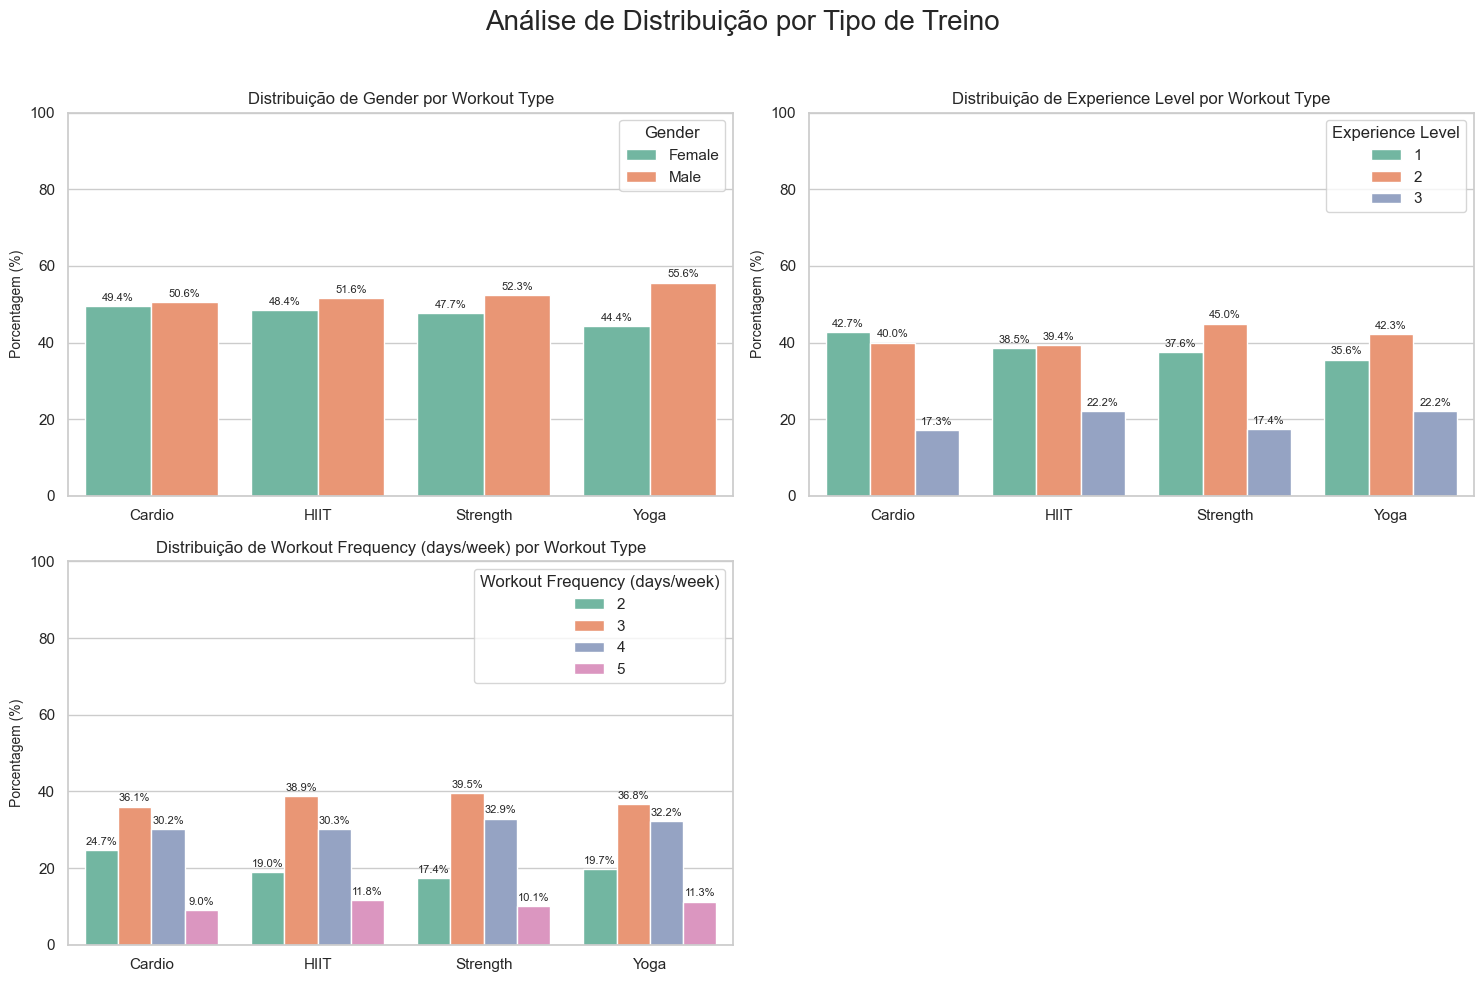

In [8]:
def plotar_em_grid(ax, dataframe, eixo_x, eixo_hue):
    grouped = dataframe.groupby([eixo_x, eixo_hue], observed=True).size().reset_index(name='Count')
    total_per_group = grouped.groupby(eixo_x, observed=True)['Count'].transform('sum')
    grouped['Percentage'] = grouped['Count'] / total_per_group * 100

    sns.barplot(data=grouped, x=eixo_x, y='Percentage', hue=eixo_hue, palette='Set2', ax=ax)

    # Adiciona os rótulos nas barras
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(x=bar.get_x() + bar.get_width() / 2, 
                    y=height + 0.8,
                    s=f'{height:.1f}%', 
                    ha='center', va='bottom', fontsize=8)

    # Customiza o eixo específico
    ax.legend(title=eixo_hue.replace('_', ' '))
    ax.set_title(f'Distribuição de {eixo_hue.replace("_", " ")} por {eixo_x.replace("_", " ")}', fontsize=12)
    ax.set_ylabel('Porcentagem (%)', fontsize=10)
    ax.set_xlabel(None) # Remove o rótulo do eixo x para não poluir
    ax.tick_params(axis='x')
    ax.set_ylim(0, 100)

    
colunas_para_plotar = ['Gender', 'Experience_Level', 'Workout_Frequency (days/week)']

# 2. Crie a figura e o grid de eixos (2 linhas, 3 colunas)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, coluna in enumerate(colunas_para_plotar):
    ax_atual = axes.flatten()[i] # Pega o eixo da vez
    plotar_em_grid(ax=ax_atual, dataframe=df, eixo_x='Workout_Type', eixo_hue=coluna)

for j in range(len(colunas_para_plotar), len(axes.flatten())):
    axes.flatten()[j].axis('off')

fig.suptitle('Análise de Distribuição por Tipo de Treino', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta para o título geral não sobrepor os gráficos

plt.show()

Esses aspectos indicam que, com os dados atuais, não há informação suficiente para uma classificação confiável, comprometendo a viabilidade do uso de modelos supervisonados para essa tarefa.

## 3. Seleção de Hiperparâmetros

Para aprimorar a modelagem, foi implementada a busca exaustiva de hiperparâmetros via GridSearch com validação cruzada estratificada (StratifiedKFold), permitindo explorar diferentes configurações de parâmetros para os modelos Random Forest e SVM. O Naive Bayes, por não possuir hiperparâmetros ajustáveis, foi incluído como baseline.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
import pandas as pd
import numpy as np

target = 'Workout_Type'
categorical_features = ['Gender', 'Experience_Level', 'Workout_Frequency (days/week)']

for col in categorical_features:
    df[col] = df[col].astype('category')

X = df.drop(columns=[target])
y = df[target]

X = pd.get_dummies(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

# Define modelos e seus grids
model_grids = {
    "Naive Bayes": {
        'model': GaussianNB(),
        'params': {}  # Não possui parâmetros
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [None, 10, 15, 20],
            'min_samples_split': [2, 4],
            'min_samples_leaf': [1, 2]
        }
    },
    "SVM Radial": {
        'model': SVC(kernel='rbf', probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 1, 0.1]
        }
    },
    "SVM Linear": {
        'model': SVC(kernel='linear', probability=True, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10]
        }
    },
    "SVM Polinomial": {
        'model': SVC(kernel='poly', probability=True, random_state=42),
        'params': {
            'C': [0.1, 1],
            'degree': [2, 3, 4],
            'gamma': ['scale', 'auto', 1, 0.1]
        }
    }
}

# Grid Search com Cross-validation
for name, config in model_grids.items():
    grid = GridSearchCV(config['model'], config['params'], cv=cv, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    accuracy = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
    f1 = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='f1_macro')

    cv_results[name] = {
        'Melhores Hiperparâmetros': grid.best_params_,
        'Accuracy': accuracy,
        'F1-Score (Macro)': f1
    }

# Exibir resultados resumidos
for model_name, result in cv_results.items():
    print(f"\n{model_name}")
    print("Melhores parâmetros:", result['Melhores Hiperparâmetros'])
    print("Accuracy médio:", np.mean(result['Accuracy']))
    print("F1-Score (macro) médio:", np.mean(result['F1-Score (Macro)']))



Naive Bayes
Melhores parâmetros: {}
Accuracy médio: 0.2892335766423358
F1-Score (macro) médio: 0.279092698805527

Random Forest
Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy médio: 0.261356805495921
F1-Score (macro) médio: 0.26022192107876935

SVM Radial
Melhores parâmetros: {'C': 1, 'gamma': 'auto'}
Accuracy médio: 0.2745813653928725
F1-Score (macro) médio: 0.2629500723937275

SVM Linear
Melhores parâmetros: {'C': 0.1}
Accuracy médio: 0.27011592958351227
F1-Score (macro) médio: 0.2493862976634505

SVM Polinomial
Melhores parâmetros: {'C': 1, 'degree': 2, 'gamma': 1}
Accuracy médio: 0.26436238729068273
F1-Score (macro) médio: 0.26358146253691783


### Métricas da classificação no banco treino

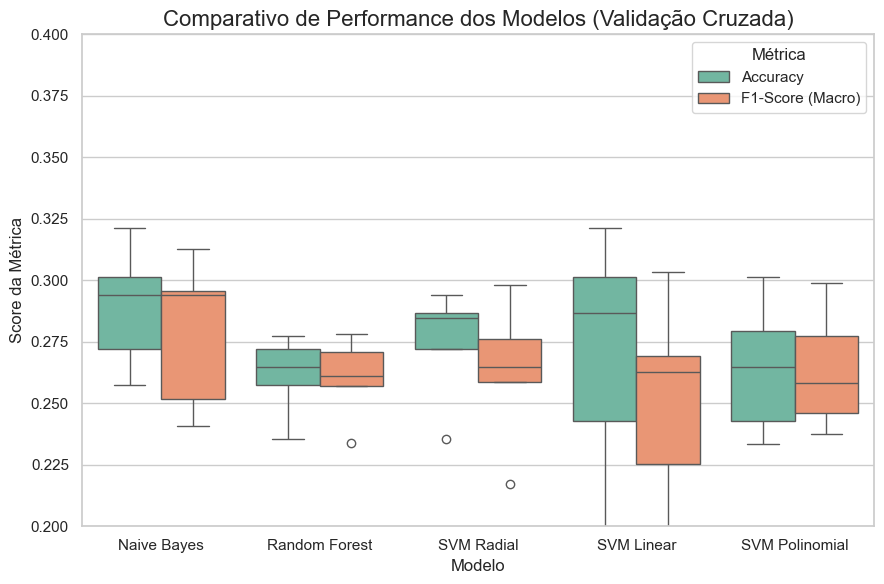

In [10]:
records = []
for model_name, metrics_dict in cv_results.items():
    for metric_name, scores_array in metrics_dict.items():
        if metric_name != 'Melhores Hiperparâmetros':
            for score in scores_array:
                records.append({
                    'Modelo': model_name,
                    'Métrica': metric_name,
                    'Score': score
                })
            
results_df_long = pd.DataFrame(records)

plt.figure(figsize=(9, 6))

# Cria o boxplot agrupado
ax = sns.boxplot(
    data=results_df_long,
    x='Modelo',
    y='Score',
    hue='Métrica', 
    palette='Set2'
)

ax.set_title('Comparativo de Performance dos Modelos (Validação Cruzada)', fontsize=16)
ax.set_ylabel('Score da Métrica', fontsize=12)
ax.set_xlabel('Modelo', fontsize=12)
ax.tick_params(axis='x')
ax.legend(title='Métrica')
ax.set_ylim(0.2, 0.4) 

plt.tight_layout()
plt.show()


Após a otimização dos hiperparâmetros, observou-se um desempenho geral semelhante ao da Fase 2, com o modelo Naive Bayes apresentando a melhor performance seguida pela SVM com kernel radial, porém com métricas ainda próximas a de um modelo aleatório.

In [15]:
# Avaliacao das metricas precision, recall e f1-score no banco teste
print("Métricas aplicadas ao banco teste \n")

result = {}
y_preds = {}

models = {}

for model_name, result in cv_results.items():
    # Treinar o modelo final com os melhores hiperparâmetros em todos os dados de treino
    best_model = model_grids[model_name]['model'].set_params(**result['Melhores Hiperparâmetros'])
    best_model.fit(X_train, y_train)
    models[model_name] = best_model
    
for name, model in models.items():
    model_test = model.fit(X_train, y_train)
    y_pred = model_test.predict(X_test)
    y_preds[name] = y_pred
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    result[name] = {         
        'Accuracy': accuracy,
        'F1-Score (Macro)': f1
        }
    print(f"Classificador {name}")
    print(classification_report(y_test, y_pred), "\n")


Métricas aplicadas ao banco teste 

Classificador Naive Bayes
              precision    recall  f1-score   support

      Cardio       0.23      0.30      0.26        77
        HIIT       0.20      0.17      0.18        66
    Strength       0.23      0.29      0.26        77
        Yoga       0.12      0.07      0.09        72

    accuracy                           0.21       292
   macro avg       0.20      0.21      0.20       292
weighted avg       0.20      0.21      0.20       292
 

Classificador Random Forest
              precision    recall  f1-score   support

      Cardio       0.25      0.27      0.26        77
        HIIT       0.27      0.23      0.25        66
    Strength       0.26      0.30      0.28        77
        Yoga       0.19      0.17      0.18        72

    accuracy                           0.24       292
   macro avg       0.24      0.24      0.24       292
weighted avg       0.24      0.24      0.24       292
 

Classificador SVM Radial
           

### Modelo base de classificação ingênua

In [16]:
# Calcula as probabilidades empíricas de cada classe
class_probs = df['Workout_Type'].value_counts(normalize=True)

# Lista de classes e seus respectivos pesos
classes = class_probs.index.tolist()
probabilities = class_probs.values.tolist()

n_samples = len(y_test)

np.random.seed(42) 
random_preds = np.random.choice(classes, size=n_samples, p=probabilities)
print(classification_report(y_test, random_preds))

accuracy = accuracy_score(y_test, random_preds)
f1 = f1_score(y_test, random_preds, average='macro')

print(f"Acurácia modelo aleatório: {accuracy:.4f}")
print(f"F1_macro modelo aleatório: {f1:.4f}")

              precision    recall  f1-score   support

      Cardio       0.23      0.22      0.23        77
        HIIT       0.16      0.17      0.16        66
    Strength       0.29      0.30      0.29        77
        Yoga       0.27      0.26      0.27        72

    accuracy                           0.24       292
   macro avg       0.24      0.24      0.24       292
weighted avg       0.24      0.24      0.24       292

Acurácia modelo aleatório: 0.2397
F1_macro modelo aleatório: 0.2374


Novamente, apesar das modificações realizadas em relação à Fase 2, o modelo ainda possui uma acurácia baixa, chegando próxima a de um modelo aleatório. Indicando novamente que as categorias não possuem uma estrutura identificável para a distinção entre elas.

## 4. Conclusão

Neste trabalho, foram aplicados conceitos fundamentais de classificação, incluindo a construção de modelos supervisionados, validação cruzada, otimização de hiperparâmetros e análise detalhada de métricas como precisão, recall e F1-score.

Embora os modelos treinados não tenham conseguido discriminar adequadamente os tipos de treino ideais para os clientes com base nos dados disponíveis, esse resultado negativo é importante. Ele evidencia que fatores fisiológicos e padrões de treino tradicionais não são suficientes para definir a prescrição ideal, sinalizando a necessidade de pesquisas futuras que incorporem variáveis adicionais ou adotem novas abordagens metodológicas.